## Add: Run model for 3 times; save snapshot of the place where error occurs --> how big should the Debug_list and Debug_list.json be enough? --> see below, pickle save model will cause problems. figures out Even though pybamm can theoretically skip in-appropriate experimental steps, may sometimes cause experiment error, should avoid that whenever possible!

## Don't rename! Don't delete the output of the cells! 

### 1st step: change initial capacity loss (to 1.5Ah) and therefore neg porosity

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize,sys
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl

In [2]:
########################     Global settings!!!
rows_per_file = 1;  Scan_end_end = 6;
purpose_i = "Full_Exp_9_3Ts_wRest" # don't overwrite Full_Exp_9_3Ts_2_Case_1_1 as another restart notebook need its output!

On_HPC =  False  
Runshort  =   True                    # a long run or a quick test
Add_Rest = False


if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 1; # manually specify
Scan_start = (i_bundle-1)*rows_per_file+1;    
Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
# interpetation: Simnon suggested, with cracking activation, heat transfer
para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters


if On_HPC:                          # Run on HPC
    Path_csv = f"InputData/{purpose_i}/" 
    Path_NiallDMA = "InputData/" 
    BasicPath=os.getcwd() 
    Para_file = Path_csv +  para_csv
else:
    import sys  
    str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
    str_path_1 = os.path.abspath(
        os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
    sys.path.append(str_path_1) 
    Path_NiallDMA = os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
    BasicPath =  os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
    Para_file = BasicPath+f'/Get_Random_sets2/{purpose_i}/'+para_csv
    
if not os.path.exists(BasicPath +"/"+ purpose):
    os.mkdir(BasicPath +"/"+ purpose);
# import all functions 
from Fun_P2 import * 

# Load the random file
parameter_names, combinations = load_combinations_from_csv(Para_file)


pool_no = len(combinations)
Indexs  = np.arange(Scan_start-1,Scan_end)
index_list = Indexs+1
""" para_dict_Same = {
   "Total ageing cycles":int(tot_cyc), # 
   "Ageing cycles between RPT":int(cyc_age), # 
   "Update cycles for ageing": int(cyc_age),
} """
# Get all para
Para_dict_list = []
# get all dictionaries
for combination in combinations:
    input_dict = {}
    for parameter_name,para_value in zip(parameter_names,combination ):
        input_dict[parameter_name] = para_value
    Para_dict_list.append(input_dict)
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 1


In [3]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]
# Update 23-06-17 
#   para="Total heat transfer coefficient [W.m-2.K-1]";
#   output="Volume-averaged cell temperature [C]"
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode surface potential difference [V]",
    "CCend SEI film overpotential [V]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Negative electrode surface potential difference [V]",
    "CDend SEI film overpotential [V]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %",
    "Error Res %","Error ageT %","Punish",
    "Dry out",]

head_pos = [ 
    "Total ageing cycles","Ageing cycles between RPT",
    "Update cycles for ageing",
    "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack = [
    Exp_All_Cell,Temp_Cell_Exp_All,
    Exp_Path,Exp_head,Exp_Temp_Cell,
    book_name_xlsx,]  
# remaining set-up for experiment and create folders

if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


### Kepp the following input! Finally reproduce a proper Experiment error or infeasible shortly during middle of cycling rather than t=0!

In [4]:

print(Para_dict_list[0]) # initial mesh: [5,5,5,60,20]
Para_dict_list[0][ 'Inner SEI lithium interstitial diffusivity [m2.s-1]']  = 8e-18
Para_dict_list[0][ 'Dead lithium decay constant [s-1]']  = 1e-10
Para_dict_list[0][ 'Lithium plating kinetic rate constant [m.s-1]']  = 1e-13
Para_dict_list[0]
# Para_dict_list[0][ 'Inner SEI lithium interstitial diffusivity [m2.s-1]'] = 9.81e-18
# run record
# 1-'[10,10,10,100,20]' - 1 hour every 26 ageing cycles

{'Scan No': 1, 'Exp No.': 9, 'Ageing temperature': 25, 'Mesh list': '[5,5,5,60,20]', 'Inner SEI lithium interstitial diffusivity [m2.s-1]': 9.81e-18, 'Dead lithium decay constant [s-1]': 1e-07, 'Lithium plating kinetic rate constant [m.s-1]': 1e-10, 'Negative electrode LAM constant proportional term [s-1]': 2.84e-09, 'Positive electrode LAM constant proportional term [s-1]': 2.98e-18, 'Negative electrode cracking rate': 5.29e-25, 'Outer SEI partial molar volume [m3.mol-1]': 5.22e-05, 'SEI growth activation energy [J.mol-1]': 10000, 'Negative cracking growth activation energy [J.mol-1]': 0, 'Negative electrode diffusivity activation energy [J.mol-1]': 17000, 'Positive electrode diffusivity activation energy [J.mol-1]': 12000, 'Contact resistance [Ohm]': 0.0115, 'Total heat transfer coefficient [W.m-2.K-1]': 20, 'Initial electrolyte excessive amount ratio': 1.1, 'Cycles within RPT': 1, 'RPT temperature': 25, 'Para_Set': 'OKane2023', 'Model option': "{'SEI': 'interstitial-diffusion limite

{'Scan No': 1,
 'Exp No.': 9,
 'Ageing temperature': 25,
 'Mesh list': '[5,5,5,60,20]',
 'Inner SEI lithium interstitial diffusivity [m2.s-1]': 8e-18,
 'Dead lithium decay constant [s-1]': 1e-10,
 'Lithium plating kinetic rate constant [m.s-1]': 1e-13,
 'Negative electrode LAM constant proportional term [s-1]': 2.84e-09,
 'Positive electrode LAM constant proportional term [s-1]': 2.98e-18,
 'Negative electrode cracking rate': 5.29e-25,
 'Outer SEI partial molar volume [m3.mol-1]': 5.22e-05,
 'SEI growth activation energy [J.mol-1]': 10000,
 'Negative cracking growth activation energy [J.mol-1]': 0,
 'Negative electrode diffusivity activation energy [J.mol-1]': 17000,
 'Positive electrode diffusivity activation energy [J.mol-1]': 12000,
 'Contact resistance [Ohm]': 0.0115,
 'Total heat transfer coefficient [W.m-2.K-1]': 20,
 'Initial electrolyte excessive amount ratio': 1.1,
 'Cycles within RPT': 1,
 'RPT temperature': 25,
 'Para_Set': 'OKane2023',
 'Model option': "{'SEI': 'interstitia

In [5]:
fs = 13; dpi = 100;
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=True;     Timelimit = int(3600*2)
Return_Sol=True;   Check_Small_Time=True; R_from_GITT = False
midc_merge,Sol_RPT,Sol_AGE,DeBug_Lists = Run_P2_Excel (
    Para_dict_list[0],BasicPath, Path_NiallDMA, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    Runshort,   Plot_Exp,Timeout, Timelimit,
    Return_Sol, Check_Small_Time, R_from_GITT,Add_Rest,
) 


Start Now! Scan 1.
Has Overwritten Initial outer SEI thickness [m] to be 7.48e-08 and Negative electrode porosity to be 0.083 to account for initial capacity loss of 1.500 Ah
Scan 1: DryOut = On
Initial electrolyte amount is  4.297675303146761 mL
Scan 1: Spent 3.557 ms on Initialization
Scan 1: Finish break-in cycle within 2 minutes, 47 seconds
Fail to read Throughput capacity for the 1th time
Scan 1: Finish post-process for break-in cycle within 1.444 s
Succeed to run the ageing set for the 0th time
Scan 1: Finish for No.0 ageing cycles within 47.818 s
Scan 1: Finish post-process for No.1 ageing cycles within 331.121 ms


2023-12-10 23:50:34.428 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Could not find consistent states: Could not find acceptable solution: Error in Function::call for 'roots' [Newton] at .../casadi/core/function.cpp:330:
.../casadi/core/rootfinder.cpp:277: rootfinder process failed. Set 'error_on_fail' option to false to ignore this error.


Fail to run RPT due to Model error or solver error for the 1th time


2023-12-10 23:52:41.561 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Could not find consistent states: Could not find acceptable solution: Error in Function::call for 'roots' [Newton] at .../casadi/core/function.cpp:330:
.../casadi/core/rootfinder.cpp:277: rootfinder process failed. Set 'error_on_fail' option to false to ignore this error.


Fail to run RPT due to Model error or solver error for the 2th time


2023-12-10 23:54:48.641 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Could not find consistent states: Could not find acceptable solution: Error in Function::call for 'roots' [Newton] at .../casadi/core/function.cpp:330:
.../casadi/core/rootfinder.cpp:277: rootfinder process failed. Set 'error_on_fail' option to false to ignore this error.


Fail to run RPT due to Model error or solver error for the 3th time
Fail due to Experiment error or infeasible
Scan 1: Fail during No.1 RPT cycles within 6 minutes, 48 seconds, due to Experiment error or infeasible
Scan 1: Getting extra variables within 872.600 us
Scan 1: Finish all plots within 6.951 s
Successfully create a excel file
Scan 1: Successfully save json file!
Scan 1: Successfully save mat file!
Scan 1: Try saving within 16.284 ms
Succeed doing something in 10 minutes, 32 seconds
This is the end of No. 1  scan


In [6]:
Sol_RPT
Sol_AGE

### Save DeBug_Lists in HPC and re-start

In [7]:
[DeBug_List_RPT,DeBug_List_AGE] = DeBug_Lists
DeBug_List_AGE

'Empty'

In [ ]:
# the only thing needs to be saved, try to save it and reload, and see how big it is ! 
DeBug_List_RPT_save = [
    Para_update, 
    Update_Cycles, 
    dict_short, 
] 


In [ ]:

import pickle
with open(BasicPath + Target+"Mats/" + str(Scan_i)+ '-DeBug_List_RPT_save.pkl', 'wb') as file:
    pickle.dump(DeBug_List_RPT_save, file)

In [ ]:
# RPT Model
import ast,json


model_options = Para_dict_list[0]["Model option"] 
# careful: need to change str to dict 
model_options = ast.literal_eval(model_options)
mesh_list = Para_dict_list[0]["Mesh list"]
mesh_list = json.loads(mesh_list)  
Call_RPT = RioCallback()   # 

Temper_i = Para_dict_list[0]['RPT temperature']
index_exp = int(Para_dict_list[0]['Exp No.'])
V_max=4.2; V_min = 2.5
Pack_return = Initialize_exp_text( index_exp, V_max, V_min, Add_Rest)
[
    exp_AGE_text, step_AGE_CD, step_AGE_CC, step_AGE_CV,
    exp_RPT_text, exp_RPT_GITT_text, exp_adjust_before_age,
    step_0p1C_CD, step_0p1C_CC, step_0p1C_RE, step_0p5C_CD
    ]   = Pack_return
ModelExperiment    = pb.Experiment( exp_RPT_text*1 + exp_adjust_before_age*1 ) 
Model = pb.lithium_ion.DFN(options=model_options)
Model_new = Model.set_initial_conditions_from(dict_short, inplace=False)
submesh_types = Model.default_submesh_types
var = pb.standard_spatial_vars  
var_pts = {
    var.x_n: int(mesh_list[0]),  
    var.x_s: int(mesh_list[1]),  
    var.x_p: int(mesh_list[2]),  
    var.r_n: int(mesh_list[3]),  
    var.r_p: int(mesh_list[4]),  
    }


Simnew = pb.Simulation(
    Model_new,
    experiment = ModelExperiment, 
    parameter_values=Para_update, 
    solver = pb.CasadiSolver(),
    var_pts = var_pts,
    submesh_types=submesh_types
)
Sol_new = Simnew.solve(
    calc_esoh=False,
    # save_at_cycles = Update_Cycles,
    callbacks=Call_RPT) 

[4.17921524 4.17921523 4.17921523 ... 4.17759024 4.17747703 4.17738684]


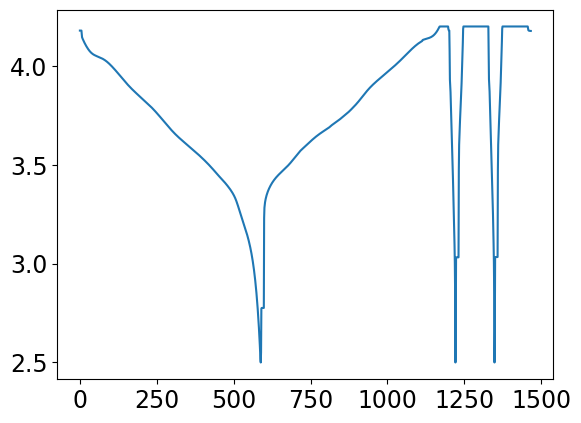

In [19]:
plt.plot(Sol_RPT[0].cycles[0]["Terminal voltage [V]"].entries)
print(Sol_RPT[0].cycles[0]["Terminal voltage [V]"].entries)

In [14]:
 
vars = [
    "Electrolyte potential [V]",
    "Terminal voltage [V]", 
    "Negative electrode porosity",
]
quick_plot = pb.QuickPlot(
    Sol_RPT[0], vars,
    time_unit='hours',n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [ ]:
midc_merge["Discharge capacity [A.h]"]